# Import

In [33]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.neighbors import NearestNeighbors
import scipy
from geosink.sinkhorn import GeoSinkhorn


## Load MNIST

In [34]:


# Download MNIST training
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

#  Convert training data to NumPy arrays
train_images = trainset.data.numpy()   # Shape: (60000, 28, 28)
train_labels = trainset.targets.numpy()  # Shape: (60000,)
test_images = testset.data.numpy()    # Shape: (10000, 28, 28)
test_labels = testset.targets.numpy()  # Shape: (10000,)

# flatten images into normalized vectors
X_train = train_images.reshape(train_images.shape[0], -1)  / 255 # Shape: (60000, 784)
X_test = test_images.reshape(test_images.shape[0], -1)  /255   # Shape: (10000, 784)
Y_train = train_labels
Y_test = test_labels
# shapes print
print(f"Train images shape: {X_train.shape}, Train labels shape: {Y_train.shape}")
print(f"Test images shape: {X_test.shape}, Test labels shape: {Y_test.shape}")

def get_image(flatten_img):
    return flatten_img.reshape(28, 28)


Train images shape: (60000, 784), Train labels shape: (60000,)
Test images shape: (10000, 784), Test labels shape: (10000,)


# COO Adjacency  and Laplacian computation

In [35]:

def get_adjancency_matrix(data : np.ndarray, n_neighbors, sigma=1, **kwargs):
    """
    
    :param data: (n_samples, n_features)
    :param n_neighbors: number of neighbors to connect to each element
    :param sigma: normalizing std for gaussian "reach"
    :param alpha: 
    :param kwargs: 
    :return: 
    """
    neighborhood = NearestNeighbors(n_neighbors=n_neighbors,**kwargs).fit(data)
    # Step 2: Find the K nearest neighbors (including self)
    distances, indices = neighborhood.kneighbors(data)
    
    # Step 3: Construct the row, col, and data for the COO sparse matrix
    row_indices = np.repeat(np.arange(data.shape[0]), n_neighbors)  # Repeat each point index n_neighbors times
    col_indices = indices.flatten()  # The flattened list of neighbors
    connexions_weights = np.exp(- (distances.flatten() / (2*sigma)) )

    # Step 4: Create a COO sparse adjacency matrix
    coo_adj_matrix = scipy.sparse.coo_matrix((connexions_weights, (row_indices, col_indices)), shape=(data.shape[0], data.shape[0]))
    
    return coo_adj_matrix
    
    
    #distances = cdist(data, data, metric='euclidean')
    #normalized_distances = distances / np.var(distances, axis=0)
    #adjacency = np.exp(-normalized_distances**2 / 2 )

EPS_LOG = 1e-6
EPS_HEAT = 1e-4


def get_symmetric_laplacian(A: np.array):
    deg = A.sum(axis=1)
    deg_sqrt = 1.0 / np.sqrt(deg + 1e-6)
    deg_sqrt = np.array(deg_sqrt)[:,0]
    deg_sqrt_inv = scipy.sparse.diags(deg_sqrt, format="coo")
    id = scipy.sparse.diags(np.ones((A.shape[0],)), format="coo")
    return id - deg_sqrt_inv @ A @ deg_sqrt_inv
    

In [36]:
#  build Laplacian 
data = X_train
nb_data = len(X_train)
adj = get_adjancency_matrix(data, 15)
L = get_symmetric_laplacian(adj)


In [37]:

# instantiate the GeoSinkhorn class
geo_sinkhorn = GeoSinkhorn(tau=5.0, order=10, method="cheb", lap=L)

def try_sinkhorn():
    delta_0 = np.zeros(nb_data,)
    delta_0[0]=1
    delta_1 = np.zeros(nb_data,)
    delta_0[1]=1
    # compute the distance between the two signals
    dist_w = geo_sinkhorn(delta_0, delta_1, max_iter=20)
    print(dist_w)

In [38]:
import matplotlib.pyplot as plt

def compare_img(index_data1,index_data2):
    
    delta_1 =np.zeros(nb_data,)
    delta_1[index_data1]=1
    delta_2 = np.zeros(nb_data,)
    delta_2[index_data2]=1
    # compute the distance between the two signals
    dist_w = geo_sinkhorn(delta_1, delta_2, max_iter=500)
    data1 = data[index_data1]
    data2 = data[index_data2]
    print("dist :", dist_w)
    img_1 = get_image(data1)
    img_2 = get_image(data2)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes
    axes[0].imshow(img_1, cmap='gray')
    axes[1].imshow(img_2, cmap='gray')
    plt.show()

# Experiment with MNIST and distances

dist : 0.005133039446571629


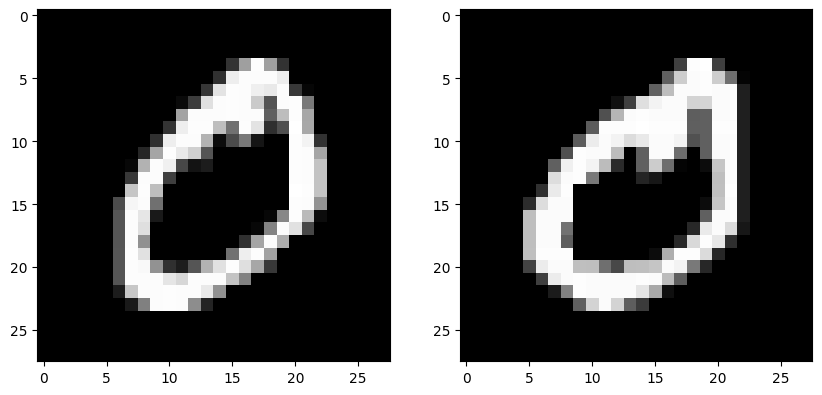

dist : 0.012280202252952885


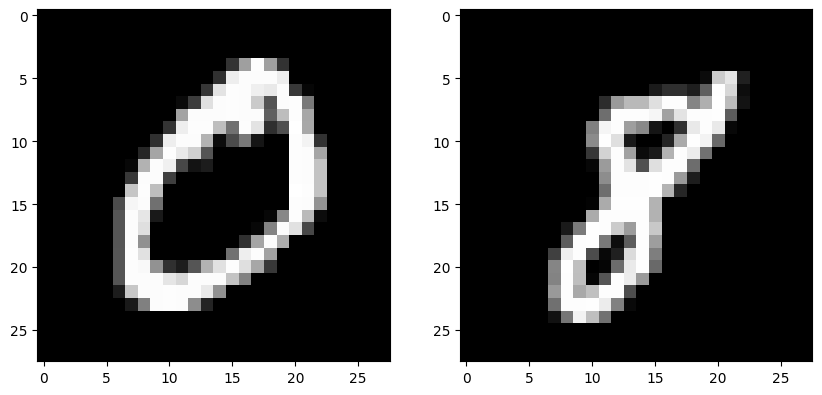

dist : 0.009092993295698092


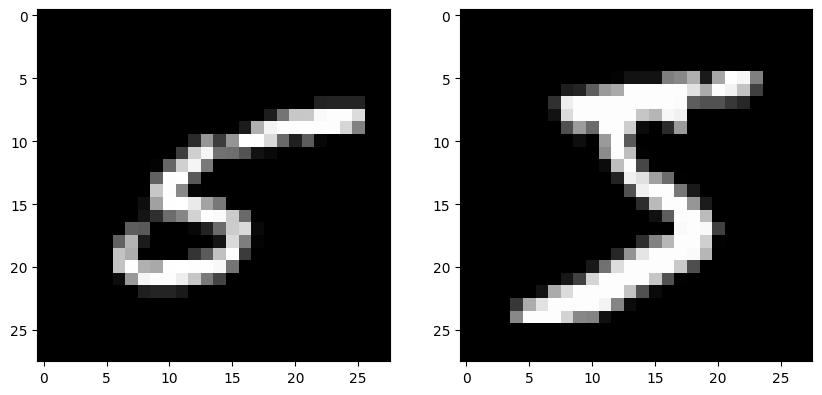

In [47]:
index_0 = np.where(train_labels==0)[0]
index_8 = np.where(train_labels==8)[0]
index_5 = np.where(train_labels==5)[0]
index_4_train = np.where(train_labels==4)[0]
index_4_test = np.where(test_labels==4)[0]
index_8_test = np.where(test_labels==8)[0]
index_9_test = np.where(test_labels==9)[0]
compare_img(index_0[0], index_0[1])
compare_img(index_0[0], index_8[0])
compare_img(index_5[12], index_5[0])

In [48]:
from ManifoldProjectLoss import ManifoldProjection
import torch


In [51]:
device = "cuda"
lr=1e-2
#img_x = X_test[0]
#img_y = X_test[3]
img_x = X_test[index_8_test[1]]
img_y = X_test[index_9_test[0]]
x = torch.tensor(img_x).to(device).requires_grad_(True)# 7
y = torch.tensor(img_y).to(device) # 0

manifold_proj = ManifoldProjection(torch.tensor(data), k_neighbor=15, closing_manifold_ratio=0.1, manifold_ratio=0.8, device=device)
optimizer = torch.optim.SGD([x], lr=lr)
num_iterations = 104
history = []
# Gradient descent loop
for i in range(num_iterations):
    optimizer.zero_grad()
    
    loss = manifold_proj(x,y)
    loss.backward()
    optimizer.step()
    
    history.append(x.clone().detach().to("cpu").numpy())
history = np.array(history)

In [52]:
fig, axes = plt.subplots(num_iterations // 4, 2, figsize=(50, 400))
axes = axes.flatten()
for k,ax in enumerate(axes):
    img = history[2*k].reshape(28,28)
    if k % 5==0:
        plt.imsave(f"{2*k}_img_mnist.png", img)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{2*k}th iteration")